In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
df = pd.read_csv("AivsHUman_with_emotion_scores.csv", encoding="UTF-8") 

In [3]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.dpi'] = 300

##load the new calculated dataset 

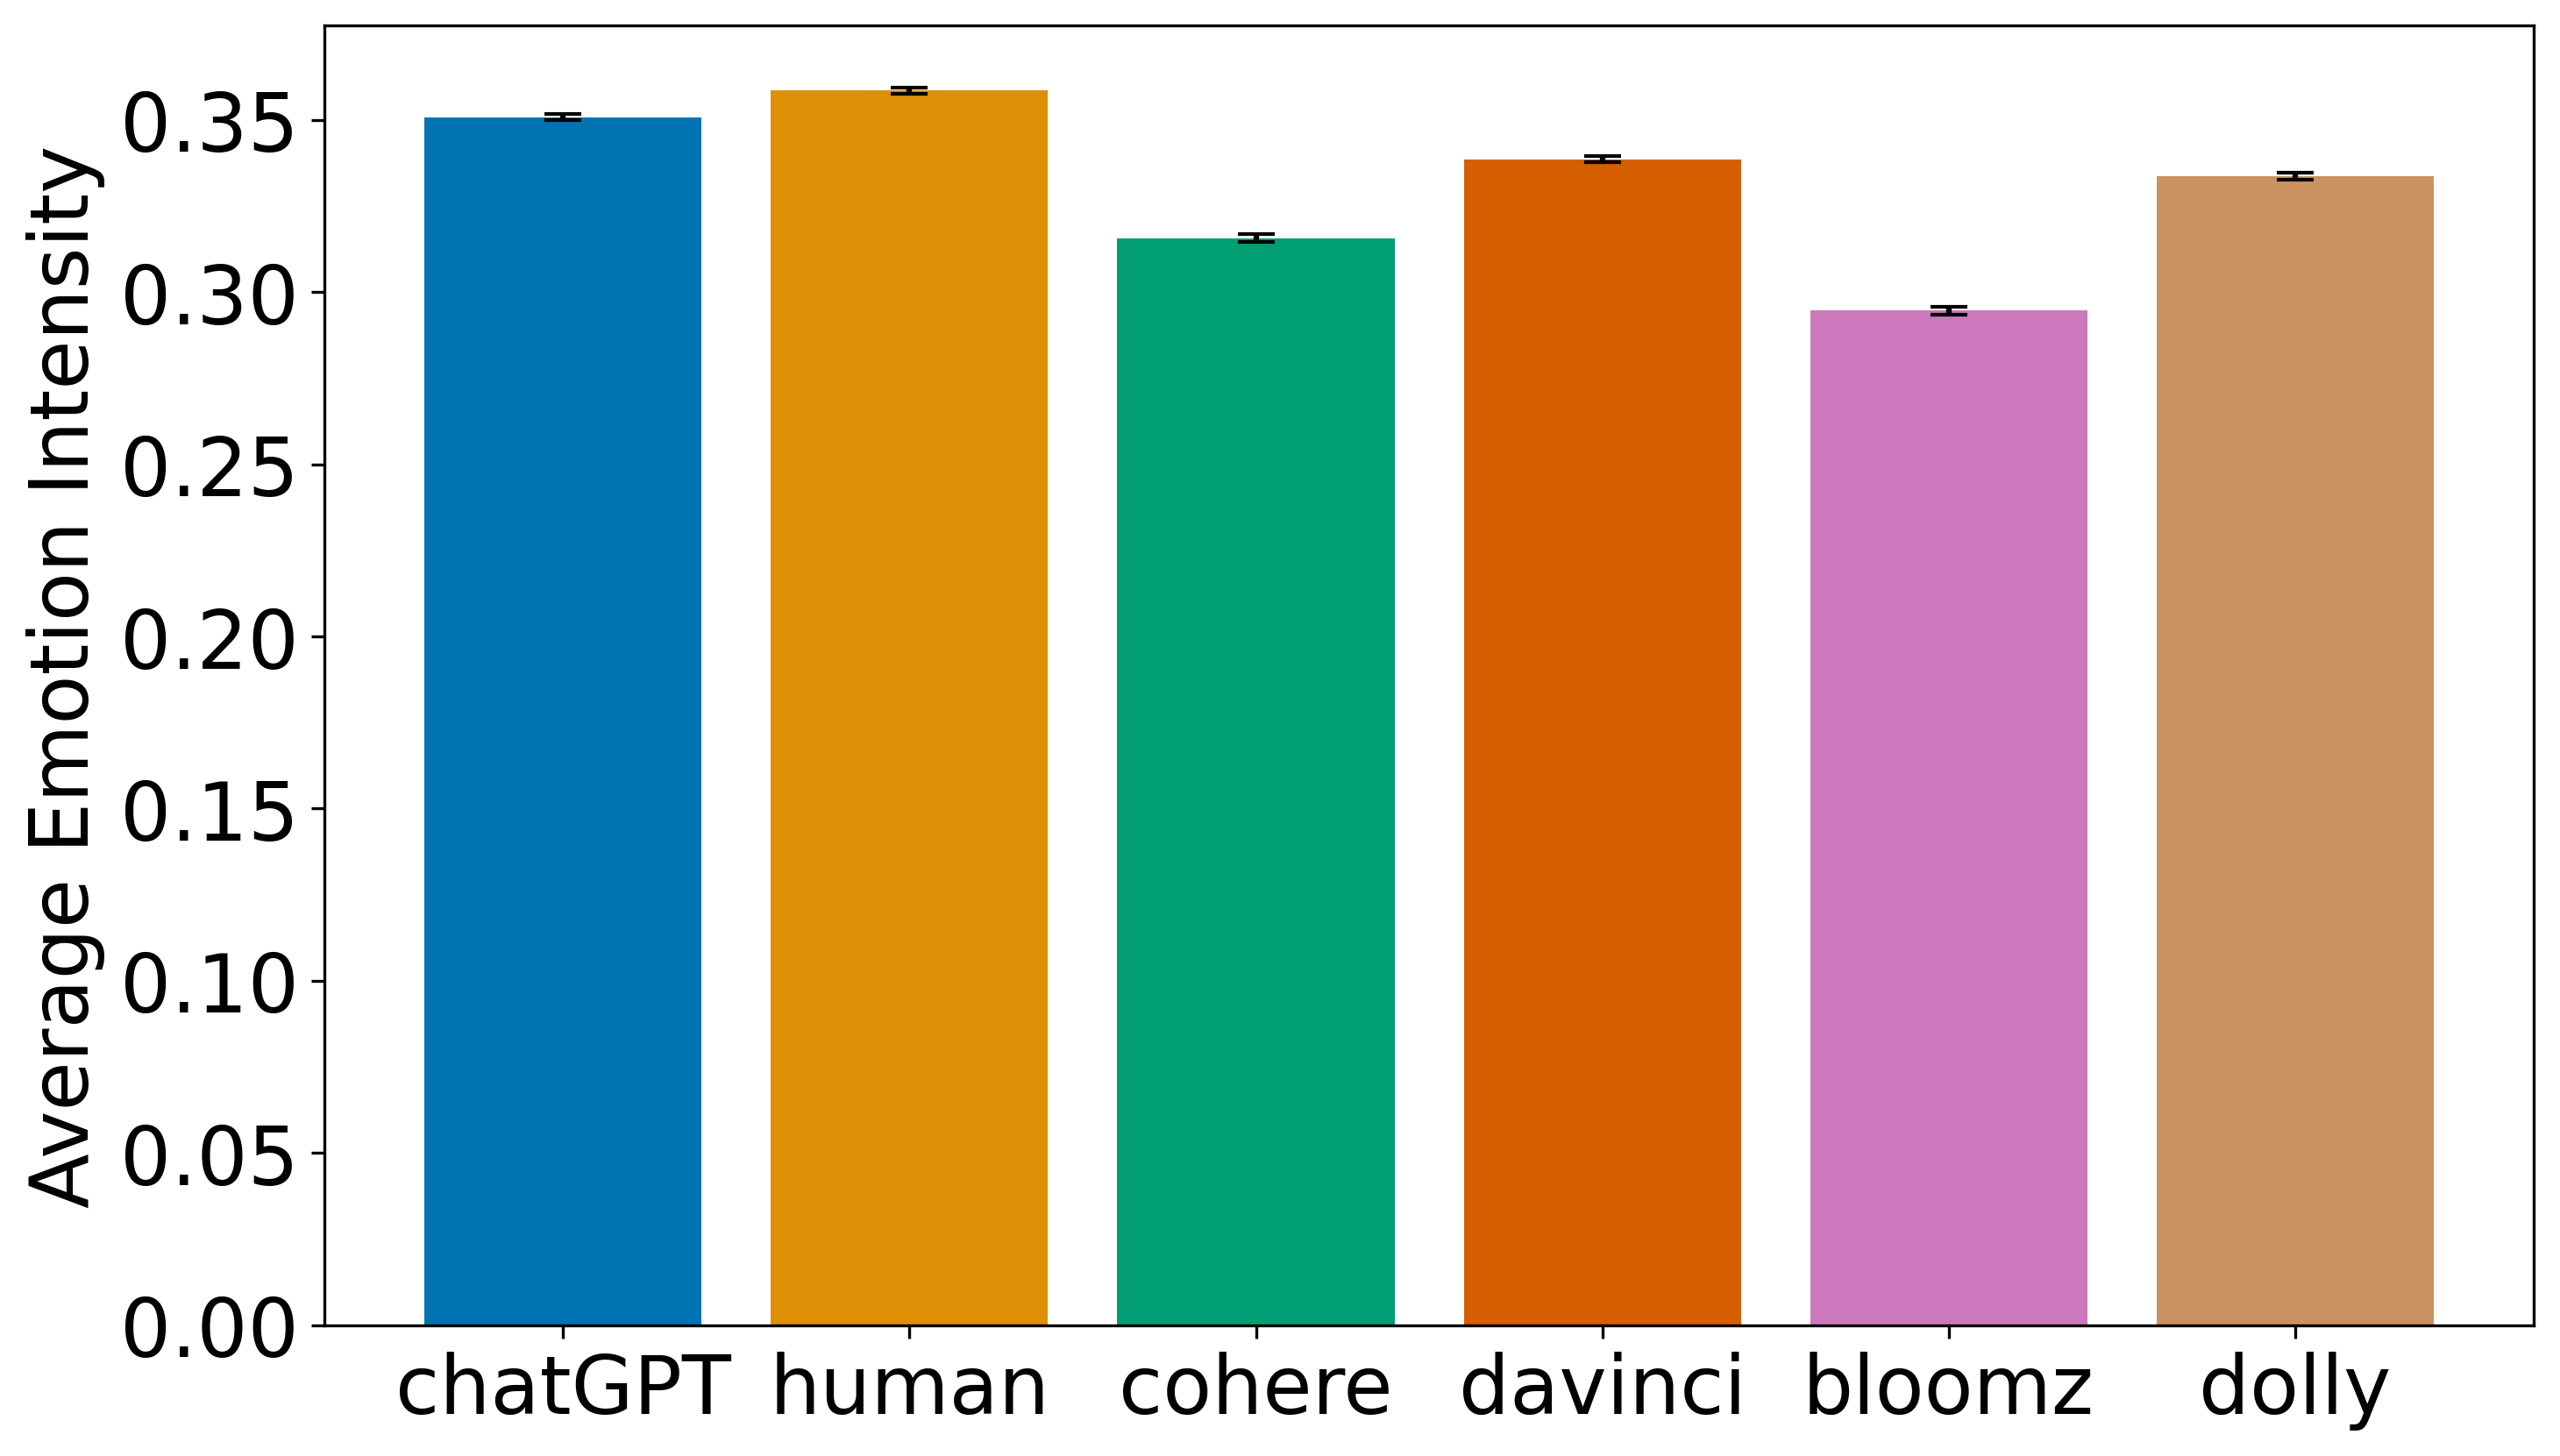

In [4]:
# Calculate unique models and sources
unique_models = df['Model'].unique()
unique_sources = df['Source'].unique()
model_order = ['chatGPT', 'human', 'cohere', 'davinci', 'bloomz', 'dolly']
# Calculate average emotion scores
emotion_columns = ['anger', 'disgust', 'fear', 'sadness', 'joy', 'anticipation',  'surprise', 'trust']
df['Average_Emotion'] = df[emotion_columns].mean(axis=1)

# Calculate the average emotion intensity and standard error for each model across all sources
avg_emotion_per_model_general = df.groupby('Model')['Average_Emotion'].mean().reindex(unique_models)
se_emotion_per_model_general = df.groupby('Model')['Average_Emotion'].sem().reindex(unique_models)

# Use a colorblind-friendly palette
colorblind_palette = sns.color_palette("colorblind", len(unique_models))

# Create a figure
plt.figure(figsize=(10, 6))

# Plotting with error bars using the colorblind-friendly palette
plt.bar(unique_models, avg_emotion_per_model_general, yerr=se_emotion_per_model_general, 
        color=[colorblind_palette[i % len(colorblind_palette)] for i in range(len(unique_models))], capsize=5)

# Adjust the title and labels with a larger font size
#plt.title('Average Emotion Intensity Across All Sources', fontsize=18)
plt.ylabel('Average Emotion Intensity')
#plt.xlabel('Model', fontsize=14)
plt.xticks()
plt.yticks()

plt.grid(False)

# Save the plot
plt.tight_layout()
plt.savefig('average_emotion_intensity_general.pdf')
plt.show()

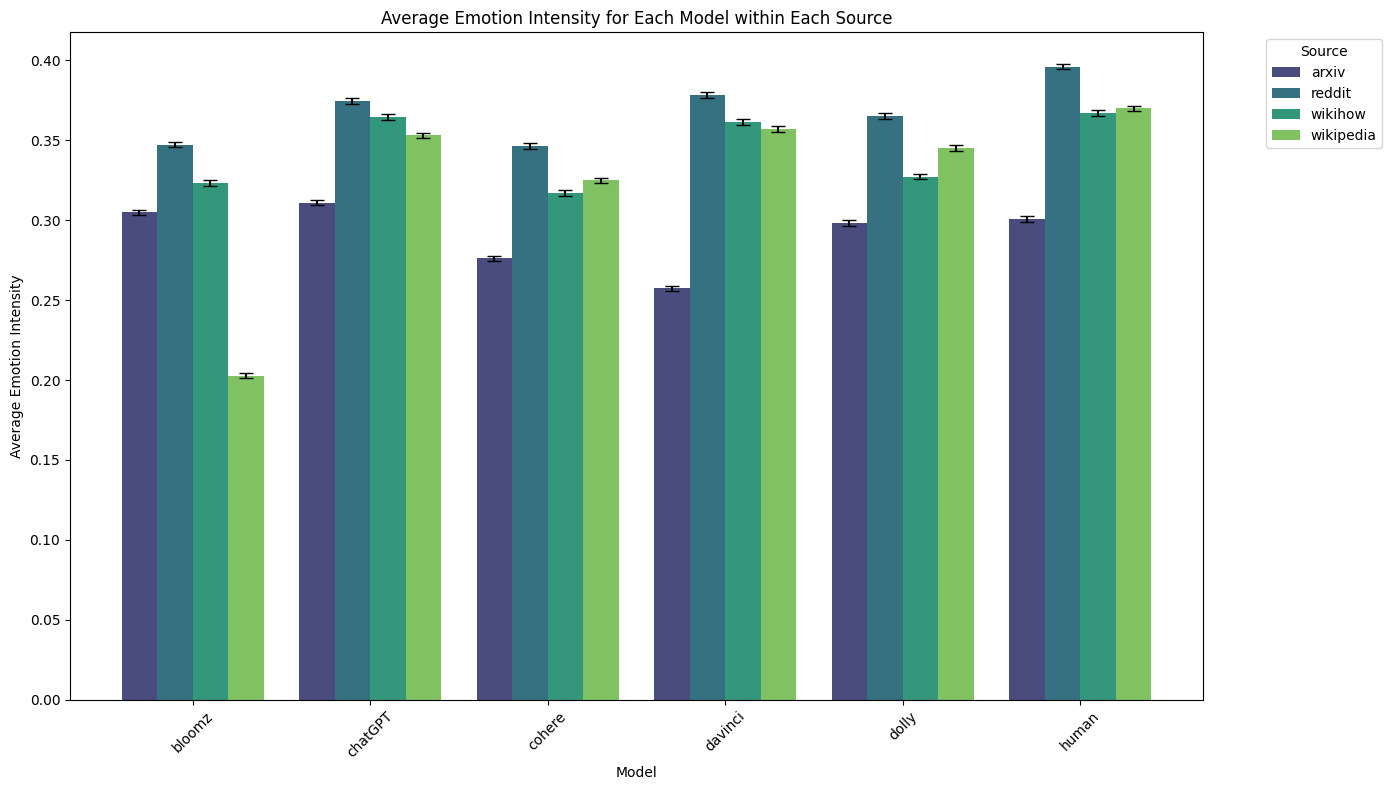

In [4]:
# Calculate the average emotion intensity and SEM for each model within each source
avg_emotion_per_model_source = df.groupby(['Source', 'Model'])['Average_Emotion'].mean().reset_index()
sem_emotion_per_model_source = df.groupby(['Source', 'Model'])['Average_Emotion'].sem().reset_index()
avg_emotion_per_model_source['SEM'] = sem_emotion_per_model_source['Average_Emotion']

# Create a bar plot with error bars
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Model', y='Average_Emotion', hue='Source', data=avg_emotion_per_model_source, palette='viridis', errorbar=None)

# Plot error bars
for i in range(len(ax.patches)):
    patch = ax.patches[i]
    model = patch.get_x() + patch.get_width() / 2  # Center of the bar
    source = avg_emotion_per_model_source.iloc[i % len(unique_sources)]['Source']  # Corresponding source
    avg_emotion = patch.get_height()  # Height of the bar (average emotion value)
    sem = avg_emotion_per_model_source[(avg_emotion_per_model_source['Model'] == unique_models[i // len(unique_sources)]) &
                                       (avg_emotion_per_model_source['Source'] == source)]['SEM'].values[0]
    
    ax.errorbar(model, avg_emotion, yerr=sem, fmt='none', c='black', capsize=5)

#plt.title('Average Emotion Intensity for Each Model within Each Source')
#plt.xlabel('Model')
plt.ylabel('Average Emotion Intensity')
plt.xticks(rotation=45)
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('average_emotion_intensity_per_model_within_each_source.png')
plt.show()

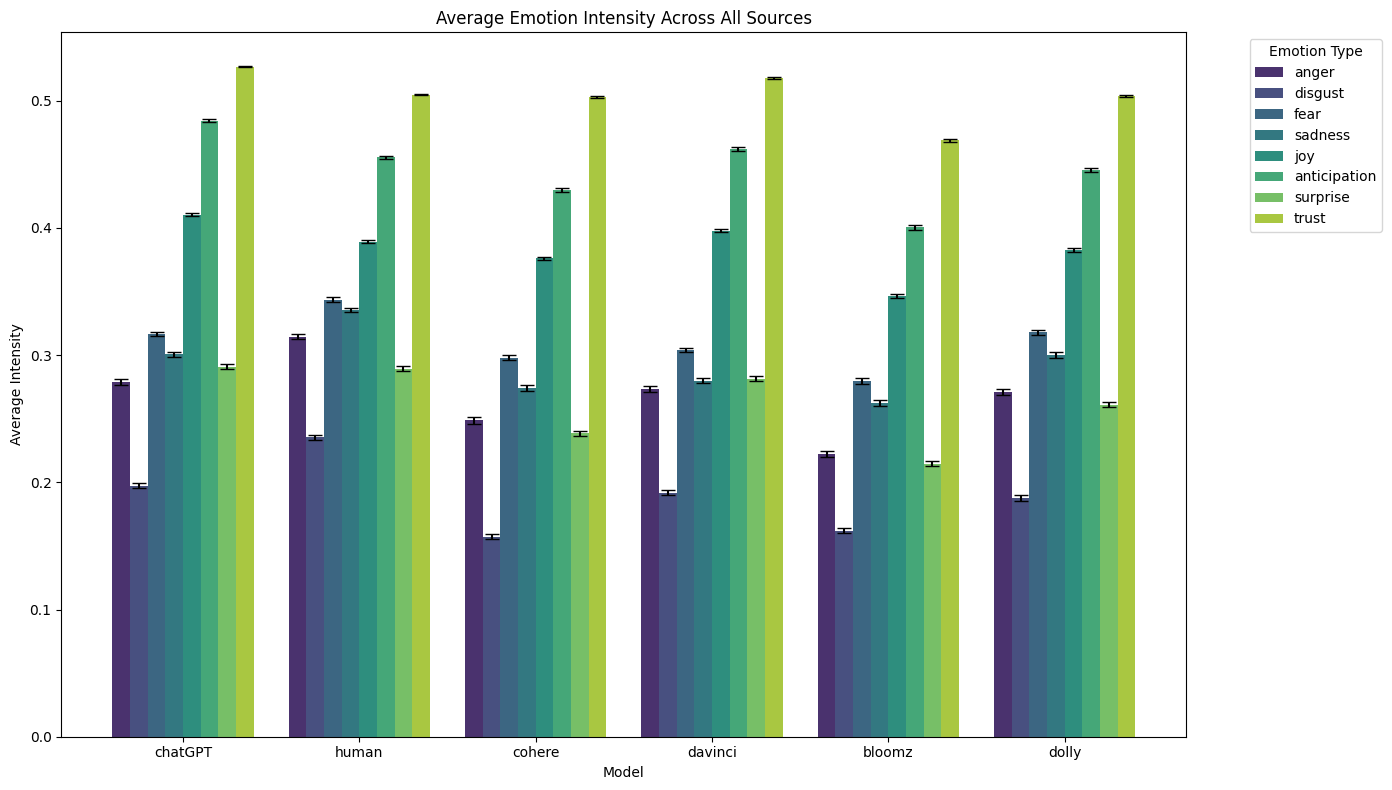

In [5]:
# Calculate the average emotion intensity and standard error for each model and emotion across all sources
avg_emotion_per_model_total = df.groupby('Model')[emotion_columns].mean().reindex(model_order)
se_emotion_per_model_total = df.groupby('Model')[emotion_columns].sem().reindex(model_order)

# Convert to long format for seaborn
avg_emotion_per_model_long_total = avg_emotion_per_model_total.reset_index().melt(id_vars='Model', value_vars=emotion_columns, var_name='Emotion', value_name='Intensity')
se_emotion_per_model_long_total = se_emotion_per_model_total.reset_index().melt(id_vars='Model', value_vars=emotion_columns, var_name='Emotion', value_name='SE')

# Merge average and SE dataframes
emotion_data_long_total = avg_emotion_per_model_long_total.merge(se_emotion_per_model_long_total, on=['Model', 'Emotion'])

# Create a figure
plt.figure(figsize=(14, 8))

# Plotting
ax = sns.barplot(x='Model', y='Intensity', hue='Emotion', data=emotion_data_long_total, palette='viridis', errorbar=None)

# Add error bars
for index, row in emotion_data_long_total.iterrows():
    model_index = model_order.index(row['Model'])
    bar = ax.patches[index]
    height = bar.get_height()
    ax.errorbar(bar.get_x() + bar.get_width() / 2, height, yerr=row['SE'], fmt='none', c='black', capsize=5)

plt.title('Average Emotion Intensity Across All Sources')
plt.ylabel('Average Intensity')
plt.xlabel('Model')
plt.grid(False)

plt.legend(title='Emotion Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig('emotion_intensity_per_model_total.png')
plt.show()

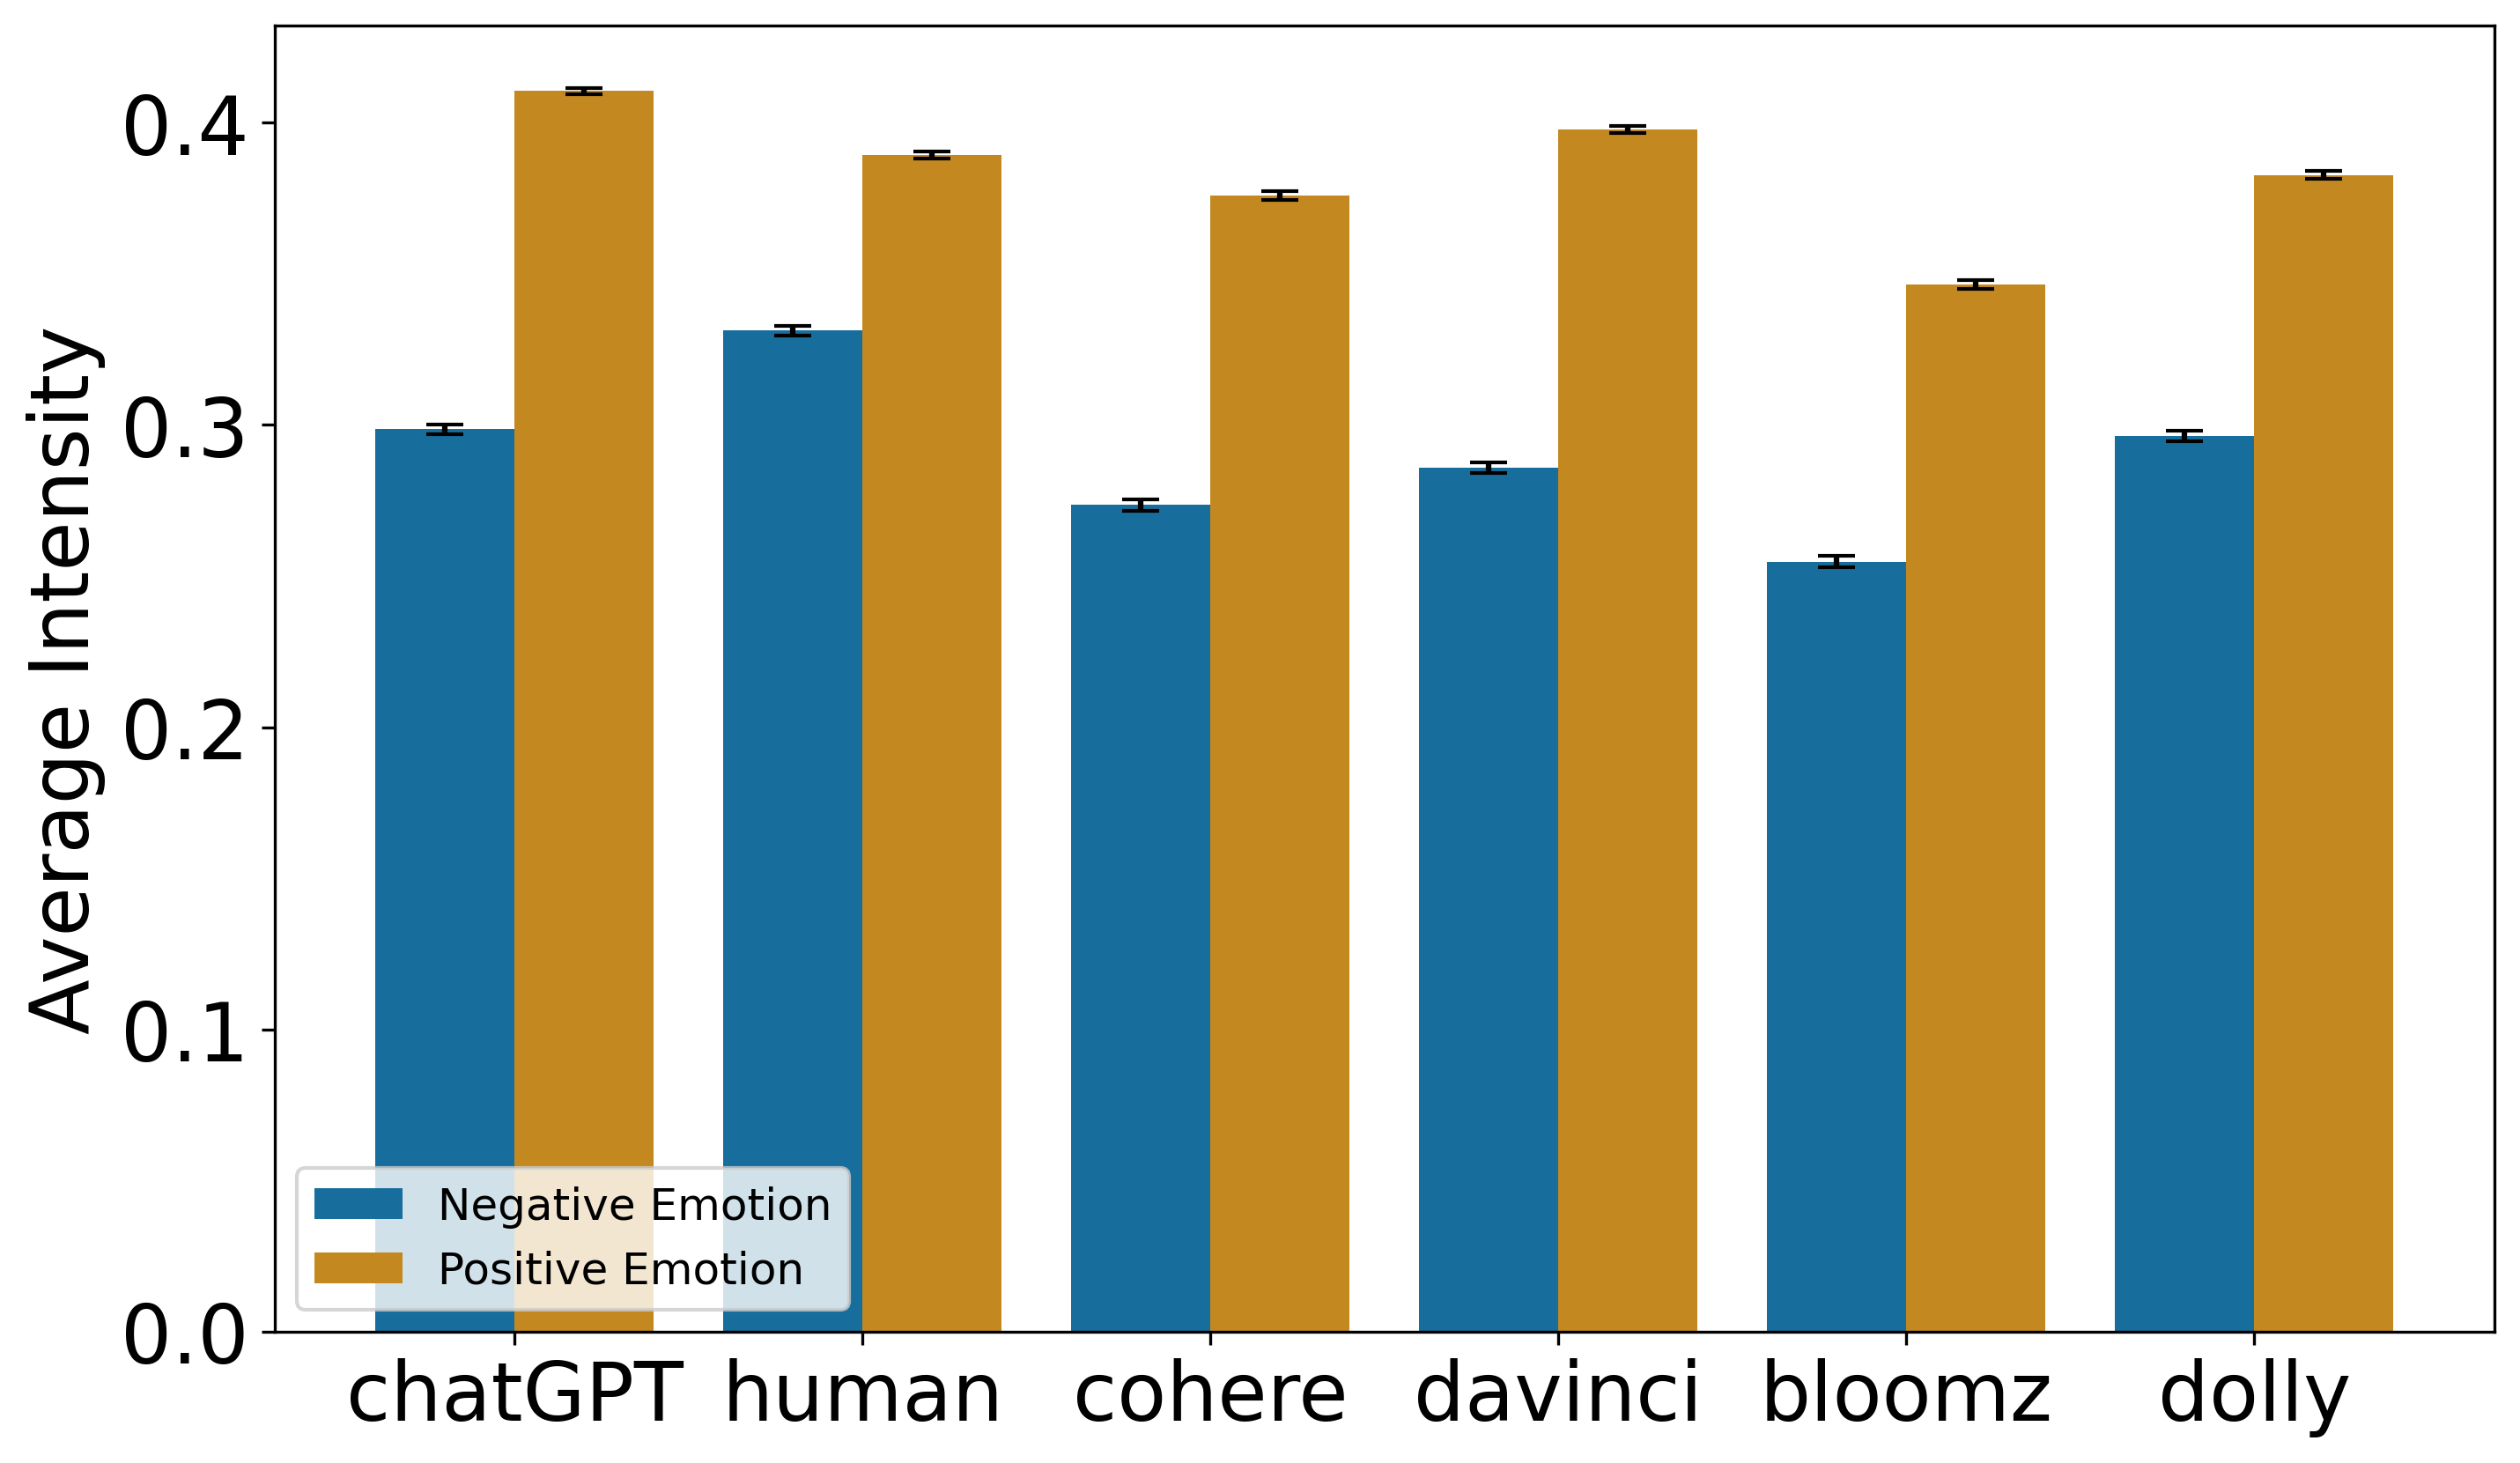

In [11]:
# Group emotions into negative and positive categories
negative_emotions = ['anger', 'fear', 'sadness']
positive_emotions = ['joy']

# Calculate the average negative and positive emotion intensity for each model
df['Negative Emotion'] = df[negative_emotions].mean(axis=1)
df['Positive Emotion'] = df[positive_emotions].mean(axis=1)

# Calculate the mean and SEM for negative and positive emotions per model
avg_emotion_per_model_total = df.groupby('Model')[['Negative Emotion', 'Positive Emotion']].mean().reindex(model_order)
se_emotion_per_model_total = df.groupby('Model')[['Negative Emotion', 'Positive Emotion']].sem().reindex(model_order)

# Convert to long format for seaborn
avg_emotion_per_model_long_total = avg_emotion_per_model_total.reset_index().melt(id_vars='Model', var_name='Emotion_Type', value_name='Intensity')
se_emotion_per_model_long_total = se_emotion_per_model_total.reset_index().melt(id_vars='Model', var_name='Emotion_Type', value_name='SE')

# Merge average and SE dataframes
emotion_data_long_total = avg_emotion_per_model_long_total.merge(se_emotion_per_model_long_total, on=['Model', 'Emotion_Type'])

# Create a figure
plt.figure(figsize=(10, 6))

# Plotting with a colorblind-friendly palette
ax = sns.barplot(x='Model', y='Intensity', hue='Emotion_Type', data=emotion_data_long_total, palette='colorblind', errorbar=None)

# Add error bars
for index, row in emotion_data_long_total.iterrows():
    model_index = model_order.index(row['Model'])
    bar = ax.patches[index]
    height = bar.get_height()
    ax.errorbar(bar.get_x() + bar.get_width() / 2, height, yerr=row['SE'], fmt='none', c='black', capsize=5)

# Adjust the title and labels with a larger font size
#plt.title('Average Negative and Positive Emotion Intensity by Model', fontsize=18)
plt.ylabel('Average Intensity')
plt.xlabel('')
plt.xticks()
plt.yticks()

plt.grid(False)

# Move legend outside the plot
plt.legend(fontsize=12, title_fontsize=14)

plt.tight_layout()

# Save the plot
plt.savefig('negative_positive_emotion_intensity_per_model_total.pdf')
plt.show()

In [12]:
import scipy.stats as stats
import scikit_posthocs as sp

# Prepare data for Kruskal-Wallis test for 'Average_Emotion'
emotion_data = [df[df['Model'] == model]['Average_Emotion'] for model in unique_models]

# Kruskal-Wallis test for Average Emotion
kw_emotion = stats.kruskal(*emotion_data)
print(f'Kruskal-Wallis test for Average Emotion: H-statistic={kw_emotion.statistic}, p-value={kw_emotion.pvalue}')

# If the Kruskal-Wallis test is significant (p-value < 0.05), perform Dunn's test
if kw_emotion.pvalue < 0.05:
    # Dunn's post-hoc test for Average Emotion
    dunn_emotion = sp.posthoc_dunn(df, val_col='Average_Emotion', group_col='Model', p_adjust='bonferroni')
    print("\nDunn's Test for Average Emotion:")
    print(dunn_emotion)


Kruskal-Wallis test for Average Emotion: H-statistic=2402.7826869433397, p-value=0.0

Dunn's Test for Average Emotion:
                bloomz        chatGPT         cohere        davinci  \
bloomz    1.000000e+00  2.432206e-261   2.136127e-18  1.375671e-153   
chatGPT  2.432206e-261   1.000000e+00  1.647690e-137   7.401683e-15   
cohere    2.136127e-18  1.647690e-137   1.000000e+00   3.548012e-64   
davinci  1.375671e-153   7.401683e-15   3.548012e-64   1.000000e+00   
dolly    3.905151e-109   1.979023e-32   1.709933e-37   8.732183e-04   
human     0.000000e+00   4.274179e-11  6.890881e-223   2.467010e-50   

                 dolly          human  
bloomz   3.905151e-109   0.000000e+00  
chatGPT   1.979023e-32   4.274179e-11  
cohere    1.709933e-37  6.890881e-223  
davinci   8.732183e-04   2.467010e-50  
dolly     1.000000e+00   1.623529e-79  
human     1.623529e-79   1.000000e+00  
